In [2]:
import sys
sys.path.append('../../')
import math

import numpy as np
import torch

from user_fun.field import D2Field
from user_fun.geom import line_sample
from user_fun.pde import ico_2D_static_factory
from user_fun.bc import data_loss_factory


def get_problem(seg_density = 32):
    field = D2Field([0,1],[0,3])
    pde_input = field.get_field_mesh([seg_density,seg_density*3])
    center = np.array([0.0, 1.3])
    threshold_distance = 0.3
    distances = np.linalg.norm(pde_input - center, axis=1)
    pde_input = pde_input[distances > threshold_distance]

    bc_left1_x = line_sample([0,0],[0,1], seg_density*2)
    bc_left2_x = line_sample([0,1.6],[0,3], seg_density*2)
    bc_up_x = line_sample([0,3],[1,3], seg_density)
    bc_right_x = line_sample([1,3],[1,0], seg_density*3)
    bc_down_x = line_sample([0,0],[1,0], seg_density)


    def generate_points_on_semicircle(n, center_x, center_y, radius):
        angles1 = np.linspace(0, 0.5*np.pi, n//2)
        angles2 = np.linspace(1.5*np.pi, 2*np.pi, n//2)
        angles = np.concatenate([angles1, angles2], axis = 0)
        x_coords = center_x + radius * np.cos(angles)
        y_coords = center_y + radius * np.sin(angles)

        points = np.column_stack((x_coords, y_coords))
        return points

    bc_left_circle = generate_points_on_semicircle(64, 0, 1.3, 0.3)

    wall_input = np.vstack([bc_left1_x,bc_left_circle,bc_left2_x,bc_right_x])
    inlet_input = bc_down_x
    outlet_input = bc_up_x

    pde_output = np.zeros([pde_input.shape[0],3])
    wall_output = np.zeros([wall_input.shape[0],2])
    inlet_output = np.zeros([inlet_input.shape[0],2])
    inlet_output[:,1] = 1.0
    outlet_output = np.zeros([outlet_input.shape[0],1])

    loss_fn = torch.nn.MSELoss()
    loss_list = [
        ico_2D_static_factory(loss_fn, 0.01),
        data_loss_factory(loss_fn, [1,2]), #wall (u,v)==0
        data_loss_factory(loss_fn, [1,2]), #inlet (u,v)==(1,0)
        data_loss_factory(loss_fn, [0]), #output (p)==0
    ]

    cloud_point_list = [
        [pde_input,pde_output],
        [wall_input,wall_output],
        [inlet_input,inlet_output],
        [outlet_input,outlet_output]
    ]
    return cloud_point_list,loss_list


cloud_point_list,loss_list = get_problem()

from user_fun.visual import process_point_sets,visualize_point_sets_interactive

point_sets = {
    "pde": cloud_point_list[0],
    "wall": cloud_point_list[1],
    "inlet": cloud_point_list[2],
    "outlet": cloud_point_list[3]
}

%matplotlib widget
results = process_point_sets(point_sets)
visualize_point_sets_interactive(results,xlim = [-0.2,1.2],ylim = [-0.2,3.2],zlim = [-1,1])

Output()

,% x,y,p (Pa),u (m/s),v (m/s)
0,0.000000,0.031905,1.809562,1.000000,0.000000
1,0.000000,0.014159,2.518666,1.000000,0.000000
2,0.022378,0.024268,1.816001,1.028800,0.196752
3,0.000000,0.969872,1.746850,1.000000,0.000000
4,0.025736,0.975638,1.685024,1.014192,-0.218056
...,...,...,...,...,...
1918,2.930000,0.000000,0.027746,0.000000,0.000000
1919,2.965000,0.006535,0.007127,0.016012,0.000552
1920,2.965000,0.000000,0.002862,0.000000,0.000000
1921,3.000000,0.006535,0.121380,0.051365,-0.008832


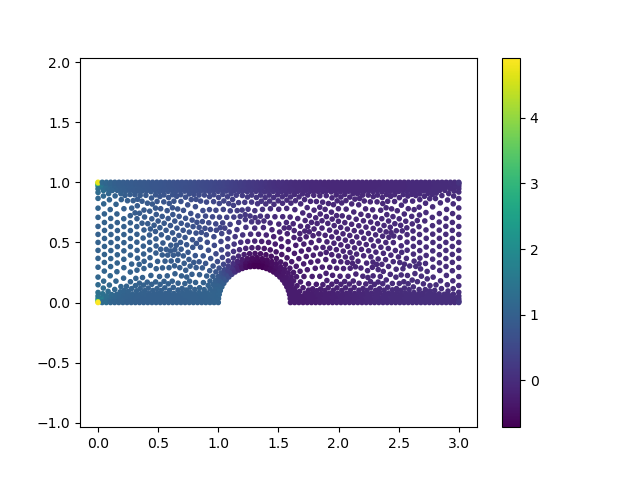

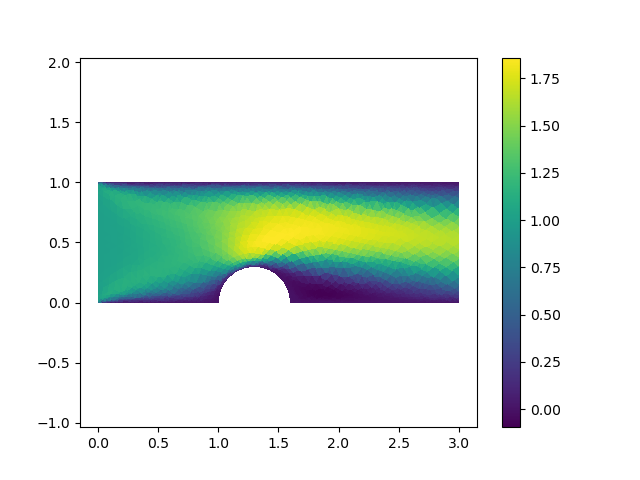

In [3]:
from user_fun.io import read_comsol
import matplotlib.pyplot as plt
import matplotlib.tri as tri

tb = read_comsol.comsol_read('half_cl.csv')

plot_x = tb.values[:,0]
plot_y = tb.values[:,1]
plot_p = tb.values[:,2]
plot_u = tb.values[:,3]
plot_v = tb.values[:,4]
plot_input = tb.values[:,0:1]
plot_output = tb.values[:,2:4]
fig, ax = plt.subplots()
im = ax.scatter(plot_x, plot_y, marker= '.',c = plot_p, cmap='viridis')
cbar = ax.figure.colorbar(im, ax=ax)
ax.axis('equal')

fig, ax = plt.subplots()
triang = tri.Triangulation(plot_x, plot_y)

# Mask off unwanted triangles.
tri_centroid_x = plot_x[triang.triangles].mean(axis=1)
tri_centroid_y = plot_y[triang.triangles].mean(axis=1)
mask = np.hypot(tri_centroid_x-1.3,tri_centroid_y-0) < 0.3
triang.set_mask(mask )
cm = ax.tripcolor(triang, plot_u, cmap='viridis')

cbar = ax.figure.colorbar(cm, ax=ax)
ax.axis('equal')


pde_input = cloud_point_list[0][0]
from scipy.interpolate import griddata

def test_eval():
    plot_input,idx = np.unique(plot_input, axis=0,return_index=True)
    pde_output = griddata(plot_input, plot_p[idx]+0.01*np.random(), pde_input, method='cubic')

tb

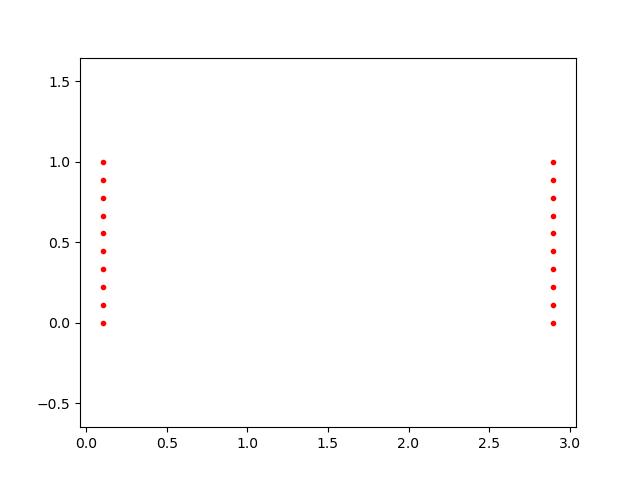

Result for x=0.1:
 [[ 0.1         0.          1.15984202 -0.00191793 -0.00276701]
 [ 0.1         0.11111111  1.18893157  1.1154566   0.17806256]
 [ 0.1         0.22222222  1.11466238  1.02858226  0.07765873]
 [ 0.1         0.33333333  1.06251309  1.01093814  0.04091005]
 [ 0.1         0.44444444  1.03050451  1.0075199   0.02171774]
 [ 0.1         0.55555556  1.01518521  1.00805232  0.00518983]
 [ 0.1         0.66666667  1.01785429  1.01230809 -0.01630503]
 [ 0.1         0.77777778  1.04436736  1.03061191 -0.05708802]
 [ 0.1         0.88888889  1.09808701  1.12715458 -0.16939791]
 [ 0.1         1.          1.07396444 -0.00216099  0.00290922]]
Result for x=2.9:
 [[ 2.90000000e+00  0.00000000e+00  1.80478565e-02  4.46972472e-04
  -5.69911966e-05]
 [ 2.90000000e+00  1.11111111e-01  1.11380934e-02  4.19744383e-01
  -3.10235925e-02]
 [ 2.90000000e+00  2.22222222e-01  6.79049942e-03  8.73229414e-01
  -9.40841991e-02]
 [ 2.90000000e+00  3.33333333e-01  2.33289999e-03  1.31187644e+00
  -1.37869

In [4]:
import numpy as np
from user_fun.io import read_comsol
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# 读取数据并提取相应的列
tb = read_comsol.comsol_read('half_cl.csv')
plot_x = tb.values[:,0]
plot_y = tb.values[:,1]
plot_p = tb.values[:,2]
plot_u = tb.values[:,3]
plot_v = tb.values[:,4]

# 将x和y坐标组合成输入
plot_input = np.column_stack((plot_x, plot_y))

# 生成x = 0.1和x = 2.9的坐标
x1 = np.full(10, 0.1)
x2 = np.full(10, 2.9)
y_coords = np.linspace(0, 1, 10)

coords_x1 = np.column_stack((x1, y_coords))
coords_x2 = np.column_stack((x2, y_coords))

# 使用插值方法获取点云数据
unique_plot_input, idx = np.unique(plot_input, axis=0, return_index=True)
p1 = griddata(unique_plot_input, plot_p[idx], coords_x1, method='cubic')
p2 = griddata(unique_plot_input, plot_p[idx], coords_x2, method='cubic')
u1 = griddata(unique_plot_input, plot_u[idx], coords_x1, method='cubic')
u2 = griddata(unique_plot_input, plot_u[idx], coords_x2, method='cubic')
v1 = griddata(unique_plot_input, plot_v[idx], coords_x1, method='cubic')
v2 = griddata(unique_plot_input, plot_v[idx], coords_x2, method='cubic')

# 结合坐标和点云数据
result_x1 = np.column_stack((coords_x1, p1, u1, v1))
result_x2 = np.column_stack((coords_x2, p2, u2, v2))

# 绘制结果
fig, ax = plt.subplots()
ax.scatter(result_x1[:, 0], result_x1[:, 1], c='red', marker='.')
ax.scatter(result_x2[:, 0], result_x2[:, 1], c='red', marker='.')
ax.axis('equal')
plt.show()

# 输出两个10*5的ndarray数组
print("Result for x=0.1:\n", result_x1)
print("Result for x=2.9:\n", result_x2)


In [5]:
import numpy as np
from user_fun.io import read_comsol
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def interpolate_puv(file_path, x1, x2, num_points):
    # 读取数据并提取相应的列
    tb = read_comsol.comsol_read(file_path)
    plot_x = tb.values[:,0]
    plot_y = tb.values[:,1]
    plot_p = tb.values[:,2]
    plot_u = tb.values[:,3]
    plot_v = tb.values[:,4]

    # 将x和y坐标组合成输入
    plot_input = np.column_stack((plot_x, plot_y))

    # 生成给定x坐标的点
    x1_coords = np.full(num_points, x1)
    x2_coords = np.full(num_points, x2)
    y_coords = np.linspace(0, 1, num_points)

    coords_x1 = np.column_stack((x1_coords, y_coords))
    coords_x2 = np.column_stack((x2_coords, y_coords))

    # 使用插值方法获取点云数据
    unique_plot_input, idx = np.unique(plot_input, axis=0, return_index=True)
    p1 = griddata(unique_plot_input, plot_p[idx], coords_x1, method='cubic')
    p2 = griddata(unique_plot_input, plot_p[idx], coords_x2, method='cubic')
    u1 = griddata(unique_plot_input, plot_u[idx], coords_x1, method='cubic')
    u2 = griddata(unique_plot_input, plot_u[idx], coords_x2, method='cubic')
    v1 = griddata(unique_plot_input, plot_v[idx], coords_x1, method='cubic')
    v2 = griddata(unique_plot_input, plot_v[idx], coords_x2, method='cubic')

    # 结合点云数据
    result_y1 = np.column_stack((p1, u1, v1))
    result_y2 = np.column_stack((p2, u2, v2))

    return coords_x1, result_y1, coords_x2, result_y2

# 使用函数并设置参数
file_path = 'half_cl.csv'
x1 = 0.1
x2 = 2.9
num_points = 10
result_x1, result_y1, result_x2, result_y2 = interpolate_puv(file_path, x1, x2, num_points)

# 输出四个矩阵
print("Result for x=0.1:\n", "Coordinates:\n", result_x1, "\nPUV values:\n", result_y1)
print("Result for x=2.9:\n", "Coordinates:\n", result_x2, "\nPUV values:\n", result_y2)


Result for x=0.1:
 Coordinates:
 [[0.1        0.        ]
 [0.1        0.11111111]
 [0.1        0.22222222]
 [0.1        0.33333333]
 [0.1        0.44444444]
 [0.1        0.55555556]
 [0.1        0.66666667]
 [0.1        0.77777778]
 [0.1        0.88888889]
 [0.1        1.        ]] 
PUV values:
 [[ 1.15984202 -0.00191793 -0.00276701]
 [ 1.18893157  1.1154566   0.17806256]
 [ 1.11466238  1.02858226  0.07765873]
 [ 1.06251309  1.01093814  0.04091005]
 [ 1.03050451  1.0075199   0.02171774]
 [ 1.01518521  1.00805232  0.00518983]
 [ 1.01785429  1.01230809 -0.01630503]
 [ 1.04436736  1.03061191 -0.05708802]
 [ 1.09808701  1.12715458 -0.16939791]
 [ 1.07396444 -0.00216099  0.00290922]]
Result for x=2.9:
 Coordinates:
 [[2.9        0.        ]
 [2.9        0.11111111]
 [2.9        0.22222222]
 [2.9        0.33333333]
 [2.9        0.44444444]
 [2.9        0.55555556]
 [2.9        0.66666667]
 [2.9        0.77777778]
 [2.9        0.88888889]
 [2.9        1.        ]] 
PUV values:
 [[ 1.80478565